# Modeling w/ Our Cleaned and Prepped Dataset

Now that I've got an extra feature in and I've made judicious decisions about how to handle missing values from our dataset, we can start modeling and see what we wind up with.

In [1]:
import pandas as pd

In [2]:
parent = pd.read_pickle('parent_f.pkl')
holes = pd.read_pickle('holes.pkl')

The 'Holes' dataset from earlier has our flag of issues, so we're going to bring it in, drop the 'product' label and do a left hand merge with our parent dataset to append the flag, then use `fillna` to put 0s in our unflagged UPCs.

In [3]:
holes.drop('Product', axis = 1, inplace = True)
holes.head()

,UPC
0,1780014500
1,82927421880
2,82927451250
3,5000050037
4,5000023891


In [4]:
holes['Hole'] = 1
holes.head()

,UPC,Hole
0,1780014500,1
1,82927421880,1
2,82927451250,1
3,5000050037,1
4,5000023891,1


In [5]:
parent = parent.merge(holes, how = 'left', on = 'UPC')
parent.head()

,UPC,Bill Units 26,Scan Units 26,UOH 26,Sell Thru 26,Bill 26,Sales 26,Bill Units 12,Scan Units 12,UOH 12,...,Sales 7,Sales_7,Sales_6,Sales_5,Sales_4,Sales_3,Sales_2,Sales_1,Days Since Last Sale,Hole
0,1113200392,240,237,3,99,638,631,104.0,105.0,-1.0,...,27.0,5.0,5.0,3.0,0.0,5.0,3.0,5.0,0,1.0
1,1113212556,86,84,2,98,412,400,46.0,45.0,1.0,...,27.0,10.0,0.0,5.0,0.0,5.0,7.0,0.0,1,1.0
2,1113213597,468,490,-22,105,365,382,168.0,197.0,-29.0,...,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,5,1.0
3,1113214544,64,63,1,98,511,504,29.0,29.0,0.0,...,32.0,0.0,8.0,16.0,8.0,0.0,0.0,0.0,3,NaN
4,1780001260,44,45,-1,102,505,517,16.0,16.0,0.0,...,23.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,4,NaN


In [6]:
parent.columns

Index(['UPC', 'Bill Units 26', 'Scan Units 26', 'UOH 26', 'Sell Thru 26',
       'Bill 26', 'Sales 26', 'Bill Units 12', 'Scan Units 12', 'UOH 12',
       'Sell Thru 12', 'Bill 12', 'Sales 12', 'Bill Units 7', 'Scan Units 7',
       'UOH 7', 'Sell Thru 7', 'Bill 7', 'Sales 7', 'Sales_7', 'Sales_6',
       'Sales_5', 'Sales_4', 'Sales_3', 'Sales_2', 'Sales_1',
       'Days Since Last Sale', 'Hole'],
      dtype='object')

In [7]:
parent.isnull().sum()

UPC                       0
Bill Units 26             0
Scan Units 26             0
UOH 26                    0
Sell Thru 26              0
Bill 26                   0
Sales 26                  0
Bill Units 12             0
Scan Units 12             0
UOH 12                    0
Sell Thru 12              0
Bill 12                   0
Sales 12                  0
Bill Units 7              0
Scan Units 7              0
UOH 7                     0
Sell Thru 7               0
Bill 7                    0
Sales 7                   0
Sales_7                   0
Sales_6                   0
Sales_5                   0
Sales_4                   0
Sales_3                   0
Sales_2                   0
Sales_1                   0
Days Since Last Sale      0
Hole                    907
dtype: int64

In [8]:
parent.fillna(0, inplace = True)
parent.isnull().sum()

UPC                     0
Bill Units 26           0
Scan Units 26           0
UOH 26                  0
Sell Thru 26            0
Bill 26                 0
Sales 26                0
Bill Units 12           0
Scan Units 12           0
UOH 12                  0
Sell Thru 12            0
Bill 12                 0
Sales 12                0
Bill Units 7            0
Scan Units 7            0
UOH 7                   0
Sell Thru 7             0
Bill 7                  0
Sales 7                 0
Sales_7                 0
Sales_6                 0
Sales_5                 0
Sales_4                 0
Sales_3                 0
Sales_2                 0
Sales_1                 0
Days Since Last Sale    0
Hole                    0
dtype: int64

In [9]:
holes.shape

(60, 2)

In [10]:
parent.Hole.sum()

56.0

From here I can see that I 4 items from the Holes set didn't match anything in our 6mo sales history - so, as previously decided - we used the left hand join to drop those w/out sales history. This would include the Maybelline product that was scanned before, and may therefore mean we're just excluding tags for items that should have already been removed from the set.

# Baseline Model

When evaluating our models, it's important to keep a baseline model in mind. Unfortunately, due to how unbalanced our set is, that's a heavy burden.

In [12]:
import matplotlib.pyplot as plt

<BarContainer object of 2 artists>

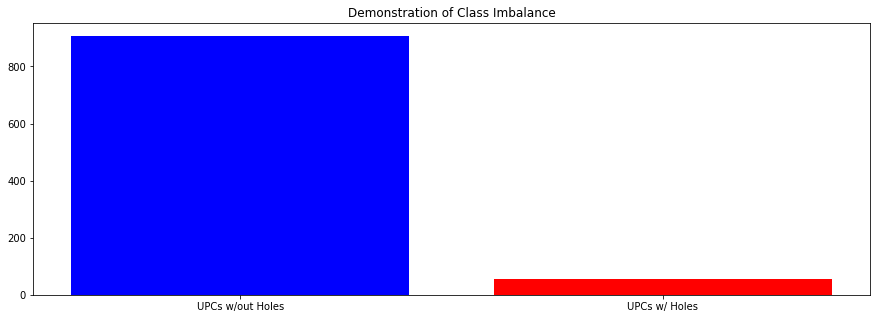

In [36]:
plt.figure(figsize = (15,5))
plt.title('Demonstration of Class Imbalance')
plt.bar(['UPCs w/out Holes', 'UPCs w/ Holes'], (parent.Hole.value_counts()[0], parent.Hole.value_counts()[1]), color = ['b', 'r'])

In [37]:
parent.Hole.value_counts()

0.0    907
1.0     56
Name: Hole, dtype: int64

So with all of our data, we only have 56 holes we can predict. We can account for this imbalance when we assign training weights, but it's important to know what our baseline model looks like.

At this point, with 56 holes, **a baseline model which assumes everything is fine, and that there are no holes, would be 94% accurate**. This means that for the tool to be useful, it must be more than 94% accurate at the least.

# Model Test - Basic Decision Tree

I want to start off with a basic Decision Tree just to see what we can get. So, to that end I'm going to import it from skl and get started.

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [37]:
y = parent.Hole
X = parent.drop(['Hole', 'UPC'], axis = 1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [39]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
tree.score(X_train, y_train)

1.0

In [41]:
tree.score(X_test, y_test)

0.8858131487889274

In [42]:
np.mean(cross_val_score(tree, X_train, y_train, cv = 5))

0.8768711995577666

At first blush, 88% accuracy seems very good. However, when you consider **that our dataset is severely imbalanced** it's much less impressive. The reality is that in our dataset w/ 963 UPCs, only 50+ have an issue. Therefore, if we had a rudimentary model that only assumed "Everything is fine", it would still be 94% accurate - which is much more accurate than the 88% accuracy we're getting from the decision tree.

We can take a look at where the missteps are by using a confusion matrix.

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
train_predict = tree.predict(X_train)
test_predict = tree.predict(X_test)

In [49]:
confusion_matrix(y_train, train_predict)

array([[634,   0],
       [  0,  40]], dtype=int64)

In [50]:
confusion_matrix(y_test, test_predict)

array([[253,  20],
       [ 13,   3]], dtype=int64)

Realistically, it looks like the model is overfitting on the test set. I can play with the hyperparamters as I try out more models to reduce this, but the accuracy does not look good. If it's only successfully pointing out 3 real issues, I'll need more options.

# Model Test - XGBoost

Since XGBoost is a big leader right now in classification, I want to try bringing it into the fold and seeing if it can improve the accuracy of the model.

In [55]:
import xgboost as xbg
from xgboost import XGBClassifier

In [73]:
xbg = XGBClassifier(nthread = 12, eval = 'auc')

In [74]:
a = xbg.fit(X_train, y_train)

In [75]:
training_preds = a.predict(X_train)
testing_preds = a.predict(X_test)

print(confusion_matrix(y_train, training_preds))

[[634   0]
 [ 22  18]]


In [76]:
confusion_matrix(y_test, testing_preds)

array([[272,   1],
       [ 15,   1]], dtype=int64)

In [78]:
np.mean(cross_val_score(xbg, X_test, y_test, cv=5 ))

0.9448173326360905

In [79]:
np.mean(cross_val_score(xbg, X_train, y_train, cv=5))

0.9361967938087341

With a cross validated accuracy of about 94% we're just sitting on the cusp of where we need to be - a sophisticated model that can at least match the least complex model in accuracy. I want to try a couple more paramters and see where I can get.

In [174]:
xbg2 = XGBClassifier(nthread = 12, eval = 'auc', scale_pos_weight= 4)
xbg2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=12, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
       seed=None, silent=True, subsample=1)

In [175]:
training_preds2 = xbg2.predict(X_train)
testing_preds2 = xbg2.predict(X_test)

print(confusion_matrix(y_train, training_preds2))

[[632   2]
 [  3  37]]


In [176]:
confusion_matrix(y_test, testing_preds2)

array([[272,   1],
       [ 14,   2]], dtype=int64)

In [177]:
np.mean(cross_val_score(xbg2, X_train, y_train, cv=5 ))

0.9257932559425097

More or less looks like I'm maxing out. I want to try a grid search with a Random Forest to see if maybe that will work; and I also still want to try a grid search with XGBoost.

# Model Test - Random Forest w/ Grid Search

From here I'm going to import the random forest classifier, as well as the Grid Search tool. However, I'm going to try refining the evaluation of my models a bit.

As a store partner, I'm mostly interested in finding the holes - less interested in total overall accuracy. This is to say that, in terms of dollars, if I invest time in investigating **bad predictions, aka false positives** I won't lose any money. However, if I **overlook a hole, because I'm getting a false negative** then I'm at risk of actually losing money.

The metric that I want to maximize, then, is not total accuracy, but recall. So, I also bring in an F1 score tool and the recall score tool.

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, f1_score, make_scorer

In [236]:
forest = RandomForestClassifier(n_estimators = 1000)
params = {'criterion': ['gini', 'entropy'],
         'max_depth': [None, 2, 4, 6, 8, 10],
         'min_samples_leaf': [2, 3, 4],
         'max_features': [None, 3, 5, 7, 9, 11]}

In [243]:
result = GridSearchCV(forest, params, scoring = make_scorer(recall_score), n_jobs = 6)
result.fit(X_train, y_train)

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 4, 6, 8, 10], 'min_samples_leaf': [2, 3, 4], 'max_features': [None, 3, 5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [244]:
result.best_score_

0.023950826621449765

In [245]:
result.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2}

In [246]:
test = RandomForestClassifier(criterion = 'gini',
                           max_depth = 6,
                           max_features = None, 
                           min_samples_leaf = 2)

In [247]:
test.fit(X_train, y_train)

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [248]:
confusion_matrix(y_train, test.predict(X_train))

array([[634,   0],
       [ 31,   9]], dtype=int64)

In [249]:
confusion_matrix(y_test, test.predict(X_test))

array([[273,   0],
       [ 16,   0]], dtype=int64)

Unfortunately, the random forest scored a very poor recall score even though it is still about 94.4% accurate.

# Model Test - XGBoost w/ Grid Search

From here I'm going to try and clean up XGBoost with a few hyperparameters as well.

In [270]:
xgb3 = XGBClassifier()
params = {'scale_pos_weight': [2,3,4,5,10,15,16,17,20],
          'objective': ['binary:logistic', 'binary:logitraw'],
          'max_depth': [6, 8, 10]}

In [271]:
xgbtest = GridSearchCV(xgb3, params, scoring = make_scorer(recall_score), n_jobs = 7)
xgbtest.fit(X_train, y_train)

C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\mulli\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=7,
       param_grid={'scale_pos_weight': [2, 3, 4, 5, 10, 15, 16, 17, 20], 'objective': ['binary:logistic', 'binary:logitraw'], 'max_depth': [6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [272]:
xgbtest.best_score_

0.15016141128900773

In [273]:
confusion_matrix(y_train, xgbtest.predict(X_train))

array([[634,   0],
       [  0,  40]], dtype=int64)

In [274]:
confusion_matrix(y_test, xgbtest.predict(X_test))

array([[269,   4],
       [ 15,   1]], dtype=int64)

This result isn't bad - it's still about 94% total accuracy with a mediocre recall score. Remember that our initial decision tree had a recall score of 3/16, and that the random forest had a recall score of 2/16.

I want to see if whether I add in interaction terms the algorithms will change. I know that so far, all the terms are independent of each other - they represent the same overall meaning, but over a smaller and smaller time scale. The deltas between these timescales might impact the model; or it's possible the dletas of the sell through percents will as well.

So, I'm going back to the drawing board to see what I can do.